In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import pyreadr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn
from tqdm import tqdm
from xgboost import XGBRegressor

# Data preprocessing

In [2]:
# load data
df = pd.DataFrame()

for path in glob.glob("data/*.RData"):
    _df = pyreadr.read_r(path)
    k = list(_df.keys())[0]
    _df =  _df[k]
    df = pd.concat([df, _df])

df = df.reset_index()
df

,index,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0,0.0,1.0,1,0.25171,3672.4,4466.3,9.5122,27.057,42.473,...,54.494,24.527,59.710,22.357,40.149,40.074,47.955,47.300,42.100,15.345
1,1,0.0,1.0,2,0.25234,3642.2,4568.7,9.4145,26.999,42.586,...,53.269,24.465,60.466,22.413,39.956,36.651,45.038,47.502,40.553,16.063
2,2,0.0,1.0,3,0.24840,3643.1,4507.5,9.2901,26.927,42.278,...,54.000,24.860,60.642,22.199,40.074,41.868,44.553,47.479,41.341,20.452
3,3,0.0,1.0,4,0.25153,3628.3,4519.3,9.3347,26.999,42.330,...,53.860,24.553,61.908,21.981,40.141,40.066,48.048,47.440,40.780,17.123
4,4,0.0,1.0,5,0.21763,3655.8,4571.0,9.3087,26.901,42.402,...,53.307,21.775,61.891,22.412,37.696,38.295,44.678,47.530,41.089,18.681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15329995,4999995,20.0,500.0,496,0.23419,3655.3,4461.7,9.3448,27.008,42.481,...,53.670,23.350,61.061,20.719,40.999,38.653,47.386,47.528,40.212,17.659
15329996,4999996,20.0,500.0,497,0.26704,3647.4,4540.2,9.3546,27.034,42.671,...,54.650,26.362,60.020,20.263,41.579,33.624,47.536,47.647,41.199,18.741
15329997,4999997,20.0,500.0,498,0.26543,3630.3,4571.6,9.4089,27.129,42.470,...,54.274,26.521,59.824,20.189,41.505,40.967,52.437,47.802,41.302,23.199
15329998,4999998,20.0,500.0,499,0.27671,3655.7,4498.9,9.3781,27.353,42.281,...,53.506,26.781,62.818,20.453,40.208,40.957,47.628,48.086,40.510,15.932


In [3]:
# preprocess data
df["faultNumber"] = df["faultNumber"].astype(int)
df = df.drop(["simulationRun", "sample", "index"], axis=1)

In [4]:
# remove 3, 9 and 15
mask = ~df["faultNumber"].isin([3, 9, 15])

In [5]:
df = df[mask]
df["faultNumber"].unique()

array([ 0,  1,  2,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 16, 17, 18, 19,
       20])

In [6]:
# features
X = df.loc[:, df.columns != "faultNumber"].values
# labels
y = df["faultNumber"].values

X.shape, y.shape

((13140000, 52), (13140000,))

In [7]:
df.columns[df.columns != "faultNumber"]

Index(['xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6',
       'xmeas_7', 'xmeas_8', 'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12',
       'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18',
       'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24',
       'xmeas_25', 'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30',
       'xmeas_31', 'xmeas_32', 'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36',
       'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 'xmv_1',
       'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9',
       'xmv_10', 'xmv_11'],
      dtype='object')

In [8]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
scaled_X.shape

(13140000, 52)

In [9]:
scaled_df = pd.DataFrame(scaled_X, columns=df.columns[df.columns != "faultNumber"])
scaled_df.head(3)

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,-0.048403,0.172463,-0.370896,0.317190,0.674038,0.295625,-0.255480,-0.073291,0.133912,-0.109065,...,-0.023099,-0.276875,-0.466629,-0.071480,0.052982,0.688629,0.655752,-0.156733,-0.000211,-0.485108
1,-0.044249,-0.510475,0.523796,0.069667,0.422894,0.638373,-0.260356,0.202214,-0.273659,-0.090802,...,-0.191197,-0.279855,-0.380834,-0.067129,0.039000,-0.476264,-0.587066,-0.145792,-0.130463,-0.397765
2,-0.070227,-0.490122,-0.010922,-0.245500,0.111128,-0.295842,-0.281081,-0.227164,-0.273659,-0.102173,...,-0.090887,-0.260867,-0.360861,-0.083757,0.047548,1.299152,-0.793705,-0.147038,-0.064116,0.136149


In [10]:
def create_samples(X, y, lookback=5):
    x_out = []
    y_out = []
    with tqdm(total=len(X)-lookback-1) as pbar:
        for i in range(len(X)-lookback-1):
            _x = X[i:i+lookback, :]
            _y = y[i+lookback+1]
            x_out.append(_x)
            y_out.append(_y)
            pbar.update(1)

    print("Preparing numpy return. This could take some seconds.")
    return np.array(x_out), np.array(y_out)

In [11]:
_x, _y = create_samples(scaled_df.values, y)
_x.shape, _y.shape

100%|█████████████████████████████████████████████████████████████████| 13139994/13139994 [00:05<00:00, 2322168.95it/s]


Preparing numpy return. This could take some seconds.


((13139994, 5, 52), (13139994,))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(_x, _y, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

# Binary classification

In [41]:
_tx = X_train[:, 0, :]
_ty = y_train
_ttx = X_test[:, 0, :]
_tty = y_test
_tx.shape, _ty.shape

((9197995, 52), (9197995,))

In [47]:
# 0 if y_train == 0 else 1

In [37]:
y_train.shape

(9197995,)

In [39]:
X_train[:, 0, :].shape

(9197995, 52)

# Model

In [42]:
reg = XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1, max_depth = 5, n_estimators = 100, early_stopping_rounds=50)

In [43]:
reg.fit(_tx, _ty, verbose=True, eval_set=[(_ttx, _tty)], eval_metric='rmse')

Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x0000025360CCC690>>
Traceback (most recent call last):
  File "C:\Users\ckeibel\Documents\lernen\modul_deep_learning\.tep-deep-learning\Lib\site-packages\xgboost\core.py", line 589, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument

KeyboardInterrupt: 
Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x0000025360CCC690>>
Traceback (most recent call last):
  File "C:\Users\ckeibel\Documents\lernen\modul_deep_learning\.tep-deep-learning\Lib\site-packages\xgboost\core.py", line 589, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument

KeyboardInterrupt: 


XGBoostError: [17:41:53] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\iterative_dmatrix.cc:231: Check failed: accumulated_rows == Info().num_row_ (9197995 vs. 27593985) : 

In [ ]:
"""
# Initialize the model
model = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1, max_depth = 5, n_estimators = 100)

# Train the model
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse', verbose=True)
"""

In [33]:
preds = reg.predict(_ttx[:100])

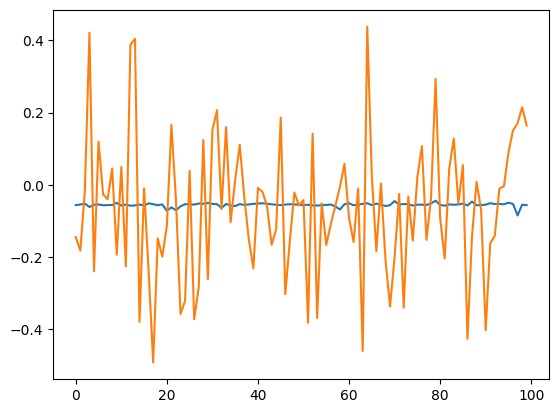

In [35]:
plt.plot(preds[:, 0])
plt.plot(_tty[:100, 0])
plt.show()